# Titanlib example with nebelhorn data

### Table of Contents  
- [Basic description of tests](#Basic-description-of-tests)
- [Load in data](#Load-in-data)
- [Map of observations](#Map-of-observations)
- [Create titanlib object](#Create-titanlib-object)
- [Buddy check](#Buddy-check)
- [Spatial consistency test](#Spatial-consistency-test)
- [Spatial consistency test resistant](#Spatial-consistency-test-resistant)
- [First guess test](#First-guess-test)




## Basic description of tests

Summary: According to MetNO SCT/SCT Resistant are the most robust tests, and the main foundation of titanlib - they use OI to compute expected values for temperature.
For this example I found SCT Resistant harder to tune and I got similar results with FGT, and Buddy Check which are more efficent. Would need to test it on different scenarios.

| Test                               | Description                                                       | Useful for us                                           |
| ---------------------------------- | ----------------------------------------------------------------- |:------------------------------------------------------- |
| Buddy check                        | Compares observation to neighbours std                            | Yes                                                     |
| Buddy event check                  | Compares observation to neighbours for a yes no event i.e. precip | No                                                      |
| Climatology range check            | User-defined range of climatological temperature values                                                              | No, could just use range                                |
| First guess test                   | Similar to SCT-resist but uses a simpler interpolation than OI so is faster. Allows us to chose background_uncertainties                                                              | Yes                                                     |
| Isolation check                    | Checks that observation has neighbours                            | No - I dont think we need to flag isolated data, it is also built into other checks                                                      |
| Metadata check                     | Checks alt, lat, lons, land area fractions                                             | No |
| Range check                        | Compares observation to a range of data                           | Yes                                                     |
| Spatial consistency test SCT           | Compares observation to what is expected from other observations found using OI                                                              | Yes                                                     |
| Spatial consistency test resistant | Like SCT but aims to be more outlier resistant by using different methods for vertical profiles                                                         | Yes                      |
| Spatial consistency test dual      | SCT but event based                                                              | No                               |



## Load in data

#### From file



In [1]:
## Read in nebelhorn data into dataframe

import xarray as xr
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import titanlib

# Folder containing files
folder_path = "/home/pcuser/titanlib/notebooks/nebelhorn"

# Define the target timestamp. Operationally this would be the most recent timestep.
# Best Time: 2022-01-22 12:00:00 with 94 stations having data, so I picked this.
target_time = pd.to_datetime("2022-01-22T12:00:00")

# List to store extracted data
data_list = []

# Loop through all NetCDF files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".nc"):
        file_path = os.path.join(folder_path, file)
        
        # Open the NetCDF file
        ds = xr.open_dataset(file_path)
        
        # Extract station name (assuming it's in the filename)
        station_name = file.split(".nc")[0] 
        
        # Convert time stored as "hours since X"
        if np.issubdtype(ds.time.dtype, np.integer) or np.issubdtype(ds.time.dtype, np.floating):
            try:
                ds["time"] = xr.decode_cf(ds).time  # Automatically converts "hours since X" format
            except Exception:
                print(f"Warning: Could not auto-decode time for {file}")
        
        # Ensure time is in datetime64 format
        ds["time"] = pd.to_datetime(ds["time"].values)
        
        # Select the nearest time
        ds = ds.sel(time=target_time, method="nearest")

        # Extract variables
        temp = ds.get("temp", None)
        rel_hum = ds.get("rel_hum", None)
        wind_speed = ds.get("wind_speed", None)
        wind_dir = ds.get("wind_dir", None)
        lat = ds.get("lat", None)
        lon = ds.get("lon", None)
        alt = ds.get("alt", None)

        # Store extracted data
        data_list.append({
            "station": station_name,
            "time": str(ds.time.values),
            "temp": float(temp.values) if temp is not None else None,
            "rel_hum": float(rel_hum.values) if rel_hum is not None else None,
#            "Wind Speed": float(wind_speed.values) if wind_speed is not None else None,  Don't really need to QC these
#            "Wind Dir": float(wind_dir.values) if wind_speed is not None else None,
            "lat": float(lat.values) if lat is not None else None,
            "lon": float(lon.values) if lon is not None else None,
            "alt": float(alt.values) if alt is not None else None,
        })
        
        ds.close()

# Convert to Pandas DataFrame for easy comparison
df = pd.DataFrame(data_list)

df.to_pickle("nebelhorn_df.pkl")


# Display the DataFrame
print(df.head())


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
             station                           time        temp    rel_hum  \
0    nebelhorn-pit_3  2022-01-22T12:00:00.000000000         NaN        NaN   
1  nebelhorn-pit_116  2022-01-22T12:00:00.000000000  271.133333  94.283333   
2  nebelhorn-pit_305  2022-01-22T12:00:00.000000000         NaN        NaN   
3  nebelhorn-pit_209  2022-01-22T12:00:00.000000000         NaN        NaN   
4  nebelhorn-pit_119  2022-01-22T12:00:00.000000000  271.225000  92.450000   

         lat        lon          alt  
0  47.409702  10.315118  1335.480957  
1  47.410301  10.296711  1025.077026  
2  47.412685  10.345387  1911.375977  
3  47.408394  10.326666  1395.333008  
4  47.408539  10.295107   976.849976  


#### From Pickle

In [2]:
## Load in a pkl for a quick way of getting the data

df = pd.read_pickle("nebelhorn_df.pkl")

## Map of observations

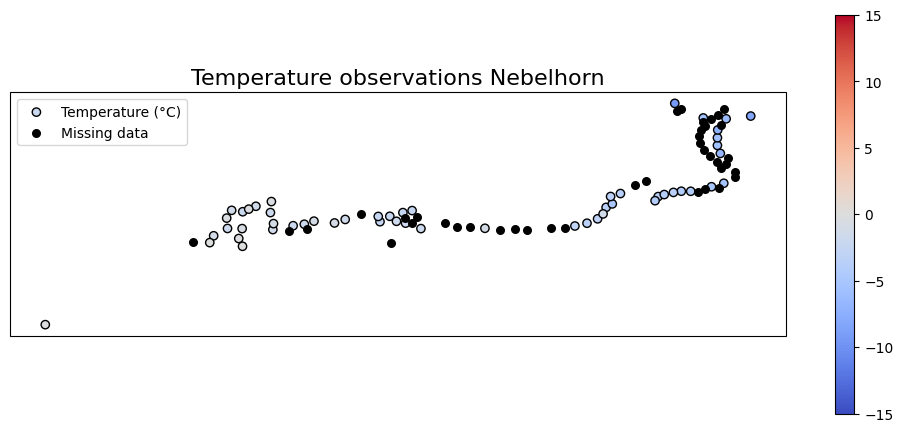

In [3]:
# Extract the relevant columns
latitude = df['lat'].values
longitude = df['lon'].values
altitude = df['alt'].values
temperature = df['temp'].values  # Observations (e.g., temperature)

# Convert to Celsius
temperature_celsius = temperature - 273.15

# Identify NaN values
is_nan = np.isnan(temperature_celsius)

# Create a map
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.COASTLINE)

# Scatter plot of temperature (valid values)
sc = ax.scatter(
    longitude[~is_nan], latitude[~is_nan],
    c=temperature_celsius[~is_nan], cmap="coolwarm", vmin=-15, vmax=15,
    edgecolors="black", transform=ccrs.PlateCarree(), label="Temperature (°C)"
)

# Scatter plot of missing values as black dots
missing_scatter = ax.scatter(
    longitude[is_nan], latitude[is_nan],
    color='black', s=30, marker='o', transform=ccrs.PlateCarree(), label="Missing data"
)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.7, pad=0.05)

# Add legend
ax.legend(loc='upper left')

# Title and display
ax.set_title("Temperature observations Nebelhorn", fontsize=16)
plt.tight_layout()
plt.show()

#### Make some spurious data, and an inversion, to try test the data

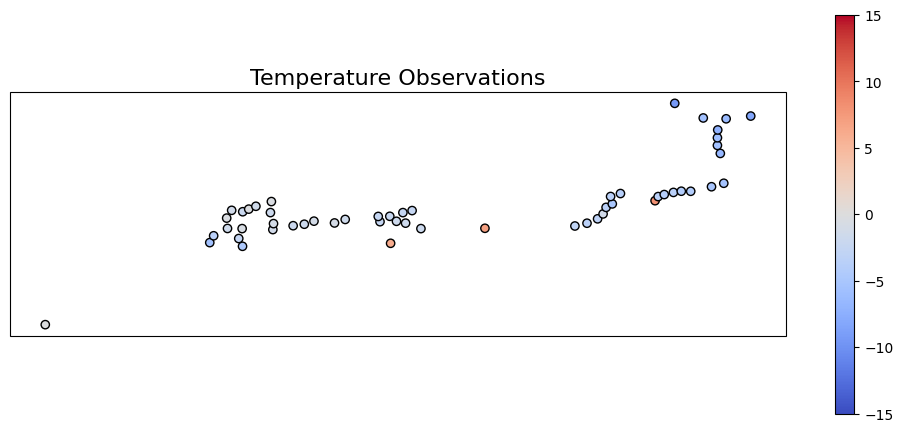

In [4]:
## There was already a slight inversion but I want to make a more obvious one
## order by altitude
df_sorted = df.sort_values(by='alt')
# Extract the relevant columns
latitude = df_sorted['lat'].values
longitude = df_sorted['lon'].values
altitude = df_sorted['alt'].values
temperature = df_sorted['temp'].values  # Observations (e.g., temperature)


temperature[6]= temperature[7]-1
temperature[5]= temperature[6]-1
temperature[4]= temperature[5]-1
temperature[3]= temperature[4]-1
temperature[2]= temperature[3]-1

# Spurious data, e.g. the snowgun is in the shed
temperature[30]= 279.15
temperature[40]= 280.15
temperature[55]= 281.15

# Converting to celsius
temperature_celsius = temperature - 273.15


# Create a map
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.COASTLINE)
# Scatter plot of temperature with 'seismic' colormap

sc = ax.scatter(
    longitude[~np.isnan(temperature)], latitude[~np.isnan(temperature)],
    c=temperature_celsius[~np.isnan(temperature)], cmap="coolwarm", vmin=-15, vmax=15, edgecolors="black",
    transform=ccrs.PlateCarree(), label="Temperature (°C)"
)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.7, pad=0.05)
# cbar.set_label("Temperature (°C)")

# Title and display
ax.set_title("Temperature Observations", fontsize=16)
plt.tight_layout()
plt.show()

## Create titanlib object
Make a titanlib point and dataset so that we can perform titanlib checks.
Dataset keeps the flags and only feeds non-flagged data into the next check.


<span style="color:red">**However, I couldn't get the Dataset working consistently correctly, so I didn't go on to use this**</span>

<span style="color:red">**It is important to filter out NaNs for the tests not to crash**</span>

In [5]:
# Filter out NaNs - important for tests not to crash
valid_mask = ~np.isnan(temperature)
latitude = latitude[valid_mask]
longitude = longitude[valid_mask]
altitude = altitude[valid_mask]
temperature = temperature[valid_mask]


# Create TitanLib Points object
points = titanlib.Points(latitude, longitude, altitude)
# Create TitanLib Dataset object
dataset = titanlib.Dataset(points, temperature)

print(points)
print(dataset)

<titanlib.Points; proxy of <Swig Object of type 'titanlib::Points *' at 0x7f0ef57753f0> >
<titanlib.Dataset; proxy of <Swig Object of type 'titanlib::Dataset *' at 0x7f0ef5775420> >


## Buddy check
The buddy check compares the observations against the average of all neighbours in a circle specified by radius [m].
Doesn't account for inversions, it uses a pre defined elev_gradient.



| Parameters      | Value                         | Description                                                                                                                                                                                                                           |
|----------------|-------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `points`        |                               | Titanlib lat/lon/alt point with stations                                                                                                                                                                                                                     |
| `values`        |                               | Observations                                                                                                                                                                                                                 |
| `radius`        | `np.full(points.size(), 5000)`| Check all neighbours within 1000 m                                                                                                                                                                                                    |
| `num_min`       | `np.full(points.size(), 3)`   | Minimum number of neighbours required to perform the test                                                                                                                                                                             |
| `threshold`     | `3`                           | Threshold of the standard deviation allowed                                                                                                                                                                                           |
| `max_elev_diff` | `500`                         | Maximum elevation difference between buddies (in metres)                                                                                                                                                                              |
| `elev_gradient` |-0.0065                                | Lapse rate to account for temperature change with elevation (optional; e.g., `-0.0065` °C/m)                                                                                                                                           |
| `min_std`       | `3`                           | If std deviation in the neighbourhood < `min_std`, this value is used instead. Should approximate typical observation error standard deviation.                                                                                      |
| `num_iterations`| `5`                           | Number of iterations. After each round, flagged outliers are excluded, and the check is repeated on remaining data to refine detection.                                                                                              |
| `obs_to_check*` | `np.full(points.size(), 1)`   | Optional: specify whether an observation should be checked (`1`) or not (`0`)                                                                                                                  |

### Return Values

| Flag  | Description         |
|:---------|-----------------|
| `0`     | OK (valid data) |
| `1`     | Bad (flagged)   |

<div align="left">



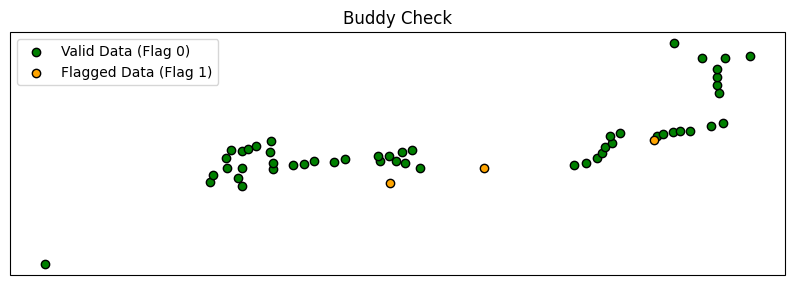

In [6]:
#Buddy check 
radius = np.full(points.size(), 5000)
num_min = np.full(points.size(), 1)
threshold = 2
max_elev_diff = 500
elev_gradient = -0.0065 ## think about inversion 
min_std = 3
num_iterations = 5
obs_to_check = np.full(points.size(), 1)

flags = titanlib.buddy_check(
    points, #Point object with station position
    temperature, 
    radius, # Search radius
    num_min, # The minimum number of buddies a station can have
    threshold, # the variance threshold for flagging a station
    max_elev_diff, # the maximum difference in elevation for a buddy (if negative will not check for heigh difference)
    elev_gradient, # linear elevation gradient with height
    min_std, # 	If the standard deviation of values in a neighborhood are less than min_std, min_std will be used instead
    num_iterations, # The number of iterations to perform
    obs_to_check # Observations that will be checked (since can pass in observations that will not be checked). 1=check the corresponding observation
)


# Extract indices based on flag values
valid_indices = np.where(flags == 0)[0]  # Green: Valid data
flagged_indices = np.where(flags == 1)[0]  # Orange: Flagged data

# Create a map
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.COASTLINE)

# Plot valid observations (green)
ax.scatter(
    longitude[valid_indices], latitude[valid_indices],
    c="green", label="Valid Data (Flag 0)", edgecolors="black", transform=ccrs.PlateCarree()
)


# Plot flagged observations (orange)
ax.scatter(
    longitude[flagged_indices], latitude[flagged_indices],
    c="orange", label="Flagged Data (Flag 1)", edgecolors="black", transform=ccrs.PlateCarree()
)


# Add title & legend
ax.set_title("Buddy Check")
ax.legend()

# Show the map
plt.show()



## Spatial consistency test 
The SCT uses optimal interpolation (OI) to compute an expected value for each observation. The background for the OI is computed from a general vertical profile of observations in the area.

 

| Name                 | Value                          | Description                                                                                                                                                                                                                                                 |
|----------------------|--------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `points`             |                                | Titanlib lat/lon/alt point with stations                                                                                                                                                                                                                           |
| `values`             |                                | Observations                                                                                                                                                                                                                                                |
| `num_min`            | `5`                            | The test will only be performed if there are at least `num_min` observations inside the outer circle.                                                                                                                                                      |
| `num_max`            | `100`                          | To reduce computation time, only the nearest `num_max` observations will be used in the outer circle, even if more are available.                                                                                                                          |
| `inner_radius`       | `100m`                        | Reuses calculations for all observations within this radius to save time.                                                                                                                                                                                  |
| `outer_radius`       | `10000m`                      | Radius for computing optimal interpolation (OI) and background.                                                                                                                                                                                            |
| `num_iterations`     | `10`                            | Number of sweeps of all observations. Observations removed in earlier iterations will not be used in later calculations.                                                                                                                                   |
| `num_min_prof`       | `5`                            | Minimum number of observations required to compute the vertical profile.                                                                                                                                                                                   |
| `min_elev_diff`      | `200m`                        | Minimum elevation difference required to compute the vertical profile.                                                                                                                                                                                     |
| `min_horizontal_scale` | `10000m`                   | Minimum horizontal decorrelation length.                                                                                                                                                                                                                    |
| `vertical_scale`     | `500m`                        | Vertical decorrelation length.                                                                                                                                                                                                                             |
| `pos`                | `np.full(points.size(), 14)`    | Number of standard deviations above expected value allowed before flagging an observation.                                                                                                                           |
| `neg`                | `np.full(points.size(), 14)`    | Number of standard deviations below expected value allowed before flagging an observation. Useful for cold inversion conditions. I had to raise this very high to allow for the inversion.                                                                                                                           |
| `eps2`               | `np.full(points.size(), 0.5)`  | Ratio of observation error variance to background variance. Lower values (e.g., 0.1) mean the observation is trusted more.                                                                                                                                |
| `obs_to_check`       | `np.full(points.size(), 1)`    | Observations to be checked: `1` = check; `0` = do not check.                                                                                                                                                                                               |


### Returned Parameters

| Name              | Value                         | Description                                                                                      |
|-------------------|-------------------------------|--------------------------------------------------------------------------------------------------|
| `flags`           |                               | Flag indicating the result of the test: `0` = OK, `1` = Bad                                      |
| `prob_gross_error`|                               | Probability of gross error for each observation                                                  |
| `rep`             |                               | Coefficient of representativity                                                                  |
     |

55
55


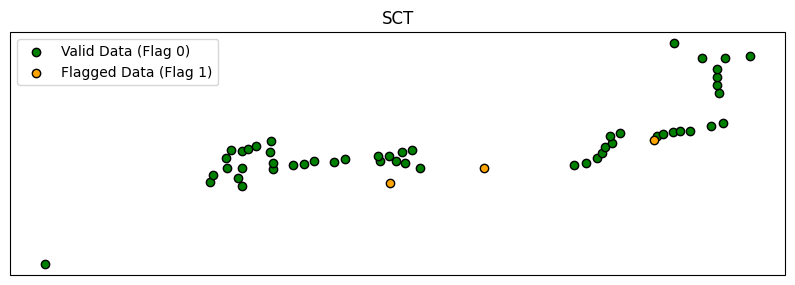

In [7]:
# SCT parameters
pos = np.full(points.size(), 14)     # max positive deviation - had to raise these alot to alow for the inversion
neg = np.full(points.size(), 14)     # max negative deviation
eps2 = np.full(points.size(), 2)  # obs-error variance ratio
obs_to_check = np.full(points.size(), 1)
# Run SCT
flags, prob, rep = titanlib.sct(
    points,
    temperature,
    5,        # num_min
    100,      # num_max
    100,    # inner_radius
    10000,   # outer_radius
    10,        # num_iterations
    5,       # num_min_prof
    200,      # min_elev_diff
    10000,    # min_horizonal_scale
    500,      # vertical_scale
    pos,
    neg,
    eps2,
    obs_to_check,
)



# Extract indices based on flag values
valid_indices = np.where(flags == 0)[0]  # Green: Valid data
flagged_indices = np.where(flags == 1)[0]  # Orange: Flagged data

# Create a map
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.COASTLINE)

# Plot valid observations (green)
ax.scatter(
    longitude[valid_indices], latitude[valid_indices],
    c="green", label="Valid Data (Flag 0)", edgecolors="black", transform=ccrs.PlateCarree()
)

# Plot flagged observations (orange)
ax.scatter(
    longitude[flagged_indices], latitude[flagged_indices],
    c="orange", label="Flagged Data (Flag 1)", edgecolors="black", transform=ccrs.PlateCarree()
)

# Add title & legend
ax.set_title("SCT")
ax.legend()

print(len(temperature))
print(len(flags))

## Spatial consistency test resistant
The sct_resistant function offers a more outlier-resistant spatial consistency test (SCT) compared to the standard sct, though it typically operates at a slower pace.

With extra background_elab_types:

| Method                   | Description                                                                                                                                                            |
|--------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `VerticalProfile`        | Estimates the background based on observation elevations, optimized for temperature profiles in complex terrains, as detailed in Frei (2014).                        |
| `VerticalProfileTheilSen`| Uses Theil-Sen linear regression (as per Wilks (2019)) to estimate the background, which is more resistant to data outliers than the VerticalProfile method.          |
| `MeanOuterCircle`        | Sets a constant background based on the mean value of observations within the outer circle.                                                                           |
| `MedianOuterCircle`      | Uses the median value of observations within the outer circle as a constant background.                                                                               |
| `External`               | Allows users to provide their own background values.                                                                                                                  |



### Parameters additional to SCT
| Parameter                           | Value             | Description                                                                 |
|-------------------------------------|-------------------|-----------------------------------------------------------------------------|
| `max_horizontal_scale`              | `100000`          | Maximum horizontal decorrelation length                                     |
| `kth_closest_obs_horizontal_scale`  | `2`               | Number of closest observations to consider in adaptive estimation of scale |
| `value_mina`                        | `temperature - 20`| Minimum admissible value                                                    |
| `value_maxa`                        | `temperature + 20`| Maximum admissible value                                                    |
| `value_minv`                        | `temperature - 1` | Minimum valid value                                                         |
| `value_maxv`                        | `temperature + 1` | Maximum valid value                                                         |


### Return flags
| Flag  | Description                                                                |
|-------|----------------------------------------------------------------------------|
| -999  | missing flag (observation not checked)                                    |
| 0     | good observation                                                          |
| 1     | bad observation                                                           |
| 11    | isolated observation, it is the only observation inside the inner circle  |
| 12    | isolated observation, less than num_min_outer observations inside outer circle |


55
55


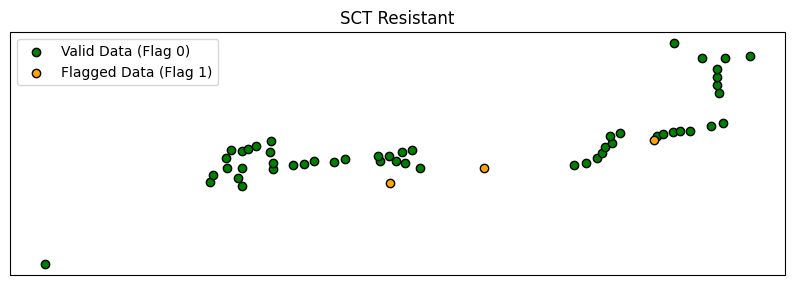

In [8]:
npoints = len(temperature)
obs_to_check = np.ones(npoints, dtype=int)
background_values = np.zeros(npoints)
background_elab_type = titanlib.VerticalProfileTheilSen
# background_elab_type = titanlib.VerticalProfile
# background_elab_type = titanlib.MeanOuterCircle
# background_elab_type = titanlib.MedianOuterCircle

num_min_outer = 3
num_max_outer = 300
inner_radius = 1000       # 200m    ## This really affected the result
outer_radius = 10000       # 10 km
num_iterations = 10
num_min_prof = 3
min_elev_diff = 100        # meters, adjust to your dataset
min_horizontal_scale = 250
max_horizontal_scale = 100000
kth_closest_obs_horizontal_scale = 2
vertical_scale = 200

tpos = np.full(npoints, 4)
tneg = np.full(npoints, 4)
eps2 = np.full(npoints, 0.5)

# Define acceptable ranges based on your data knowledge, for example ±20 K and ±1 K valid ranges
values_mina = temperature - 20
values_maxa = temperature + 20
values_minv = temperature - 1
values_maxv = temperature + 1

debug = False
basic = True


flags, scores = titanlib.sct_resistant(points, temperature, obs_to_check, background_values, 
                      background_elab_type, num_min_outer, num_max_outer, 
                      inner_radius, outer_radius, num_iterations, num_min_prof, 
                      min_elev_diff, min_horizontal_scale, max_horizontal_scale, 
                      kth_closest_obs_horizontal_scale, vertical_scale, 
                      values_mina, values_maxa, values_minv, values_maxv, 
                      eps2, tpos, tneg, debug, basic)


# Extract indices based on flag values
valid_indices = np.where(flags != 1)[0]  # Green: Valid data
flagged_indices = np.where(flags == 1)[0]  # Orange: Flagged data

# Create a map
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.COASTLINE)


# Plot valid observations (green)
ax.scatter(
    longitude[valid_indices], latitude[valid_indices],
    c="green", label="Valid Data (Flag 0)", edgecolors="black", transform=ccrs.PlateCarree()
)

# Plot flagged observations (orange)
ax.scatter(
    longitude[flagged_indices], latitude[flagged_indices],
    c="orange", label="Flagged Data (Flag 1)", edgecolors="black", transform=ccrs.PlateCarree()
)




# Add title & legend
ax.set_title("SCT Resistant")
ax.legend()

print(len(temperature))
print(len(flags))


## First guess test
FGT, First Guess Test implements a streamlined version of the Spatial Consistency Test (SCT), which is less computationally intensive compared to OI-based (Optimal Interpolation) SCTs.


| Parameter                  | Value                              | Description                                                                                                                                                            |
|----------------------------|------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `points`                   |                                    | Point object with station position                                                                                                                                     |
| `values`                   |                                    | Observations                                                                                                                                                           |
| `obs_to_check`             | `np.ones(points.size(), dtype=int)`| Observations that will be checked (since can pass in observations that will not be checked). `1` = check the corresponding observation                                |
| `background_values`        | `np.zeros(N)`                      | External background value (not used if `background_elab_type != external`)                                                                                            |
| `background_uncertainties`| `np.ones(N)`                       | Uncertainty of the external background value (not used if `background_elab_type != external`, optional when `background_elab_type = external`)                        |
| `background_elab_type`    | `titanlib.VerticalProfile`         | One of: `VerticalProfile`, `VerticalProfileTheilSen`, `MeanOuterCircle`, `external`                                                                             |
| `num_min_outer`           | `3`                                | Minimum number of observations inside the outer circle to compute FGT                                                                                                  |
| `num_max_outer`           | `10`                               | Maximum number of observations inside the outer circle used                                                                                                            |
| `num_min_prof`            | `3`                                | Minimum number of observations to compute vertical profile                                                                                                             |
| `inner_radius`            | `1000`                            | Radius for flagging [m]                                                                                                                                                |
| `outer_radius`            | `10000`                            | Radius for computing OI and background [m]                                                                                                                             |
| `num_iterations`          | `5`                               | Number of FGT iterations                 |                                                                                                                              |
| `min_elev_diff`           | `100`                              | Minimum elevation difference to compute vertical profile  [m]|                   
| `tpos`              | `np.ones(N) * 4`                  | Positive standard deviation allowed             
| `tneg`              | `np.ones(N) * 4`                  | Negative standard deviation allowed    
| `value_mina`              | `temperature - 20`                 | Minimum admissible value                                                                                                                                               |
| `value_maxa`              | `temperature + 20`                 | Maximum admissible value                                                                                                                                               |
| `value_minv`              | `temperature - 1`                  | Minimum valid value                                                                                                                                                    |
| `value_maxv`              | `temperature + 1`                  | Maximum valid value                      |                   | `debug`                   | `Boolean`                            | Verbose output                         |                                                                                                                                |
| `basic`                   | `Boolean`                            | Verbose output                                                                                                                                                         |


| Returned parameters                     |              |
| ----------------------   | :------------ |
| flags                    |    0=OK, 1=bad, 11/12 = isolated
| scores                   |  FGT-score. The higher the score, the more likely is the presence of a gross measurement error|


FGT loop - Removing 3 observations. Number of tests 25
0.00239921 secs
FGT loop - Removing 0 observations. Number of tests 3
0.000167131 secs
Stopping early after 2 iterations
QC missing - Removing 0 observations. Number of tests 0
2.14577e-06 secs
Re-check bad obs - Removing 3 observations. Number of tests3
9.799e-05 secs
>> Total Time 0.00271392secs


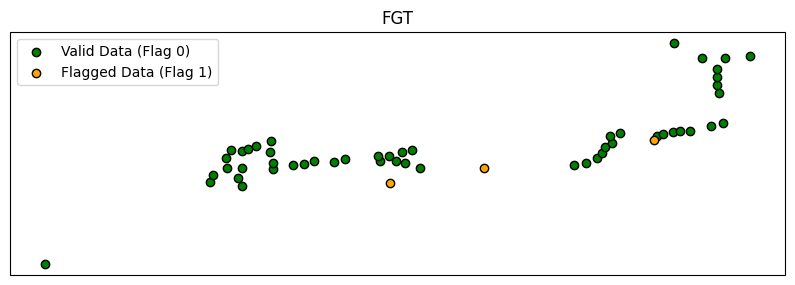

In [9]:
N = len(latitude)
obs_to_check = np.ones(points.size(), dtype=int)
background_values = np.zeros(N)
background_uncertainties = np.ones(N)
# background_elab_type = titanlib.VerticalProfileTheilSen
background_elab_type = titanlib.VerticalProfile
num_min_outer = 3
num_max_outer = 10
inner_radius = 1000
outer_radius = 10000
num_iterations = 5
num_min_prof = 3
min_elev_diff = 100
values_mina = temperature - 20
values_maxa = temperature + 20
values_minv = temperature - 1
values_maxv = temperature + 1
tpos = np.ones(N) * 4
tneg = np.ones(N) * 4
debug = False
basic = True

flags, scores = titanlib.fgt(points, temperature, obs_to_check,
    background_values, 
    background_uncertainties, 
    background_elab_type, 
    num_min_outer, 
    num_max_outer, 
    inner_radius, 
    outer_radius, 
    num_iterations, 
    num_min_prof, 
    min_elev_diff, 
    values_mina, 
    values_maxa, 
    values_minv, 
    values_maxv, 
    tpos, 
    tneg, 
    debug, 
    basic   
)


# Extract indices based on flag values
valid_indices = np.where(flags != 1)[0]  # Green: Valid data  ## There are other flags to indicate isolated
flagged_indices = np.where(flags == 1)[0]  # Orange: Flagged data

# Create a map
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.COASTLINE)

# Plot valid observations (green)
ax.scatter(
    longitude[valid_indices], latitude[valid_indices],
    c="green", label="Valid Data (Flag 0)", edgecolors="black", transform=ccrs.PlateCarree()
)


# Plot flagged observations (orange)
ax.scatter(
    longitude[flagged_indices], latitude[flagged_indices],
    c="orange", label="Flagged Data (Flag 1)", edgecolors="black", transform=ccrs.PlateCarree()
)

# Add title & legend
ax.set_title("FGT")
ax.legend()